In [1]:
!pip install pretty-confusion-matrix
!pip install transformers
!pip install pytorch-transformers
!pip install -U sentence-transformers
!pip install matplotlib==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 767.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.9/201.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: tomli
    Found existing installation: tomli 2.0.1
    Uninstalling tomli-2.0.1:
      Successfully uninstalled tomli-2.0.1
  Attempting uninstall: pyflakes
    Found existing installation: pyflakes 2.4.0
    Uninstalling pyflakes-2.4.0:
      Successfully uninstalled pyflakes-2.4.0
  Attempting uninstall: pycodestyle
    Found existing installation: pycodestyle 2.8.0
    Uninstalling pycodestyle-2.8.0:
      Successfully uninstalled pycodestyle-2.8.0
  Attempting uninstall: flake8
    Fo

In [2]:
import numpy as np 
import pandas as pd 
import csv
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
## IF YOU WANT TO MOUNT TO GOOGLE DRIVE, UNCOMMENT THE CODE BELOW ##
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
NUM_OF_ASPECTS = 5
EPOCHS = 2
LSTM_UNITS = 256
MAXLEN = 768

## ADD PATH OF THE PRE-TRAINED MODEL HERE ##
# LOAD_PATH = './TOXIC-BERT-20epoch.h5'
LOAD_PATH =''

## LOAD DATA

In [5]:
## LOAD EMBEDS DATASET

def loadPickle(name):
    
    ## ADD YOUR BASE PATH TO OUR UR. EXAMPLE : ##
    # BASE_PATH = '../iitpolitenesslevels-DATASET/'
    BASE_PATH = ''

    LOAD_PATH = BASE_PATH+name+'_train.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        train_embeds = pickle.load(handle)
        handle.close()

    LOAD_PATH = BASE_PATH+name+'_test.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        test_embeds = pickle.load(handle)
        handle.close()
        
    LOAD_PATH = BASE_PATH+name+'_val.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        val_embeds = pickle.load(handle)
        handle.close()
        
    y_train = pd.read_csv(BASE_PATH+'y_train.csv')
    y_val = pd.read_csv(BASE_PATH+'y_val.csv')
    y_test = pd.read_csv(BASE_PATH+'y_test.csv')
    
    reviews_train = pd.read_csv(BASE_PATH+'train.csv')
    reviews_val = pd.read_csv(BASE_PATH+'val.csv')
    reviews_test = pd.read_csv(BASE_PATH+'test.csv')
    
    print('\n***** LOADED '+ name+' *****\n')
    print(f'TRAIN SHAPE : {train_embeds.shape}\nTEST SHAPE : {test_embeds.shape}\nVAL SHAPE : {val_embeds.shape}\nY-TRAIN SHAPE : {y_train.shape}\nY-TEST SHAPE : {y_test.shape}\nY-VAL SHAPE : {y_val.shape}')

    return train_embeds, test_embeds, val_embeds, y_train, y_test, y_val, reviews_train, reviews_val, reviews_test

train_embeds, test_embeds, val_embeds, y_train, y_test, y_val, reviews_train, reviews_val, reviews_test = loadPickle('TOXIC-BERT')


***** LOADED TOXIC-BERT *****

TRAIN SHAPE : (4224, 1, 768)
TEST SHAPE : (792, 1, 768)
VAL SHAPE : (264, 1, 768)
Y-TRAIN SHAPE : (4224, 8)
Y-TEST SHAPE : (792, 8)
Y-VAL SHAPE : (264, 8)


2022-12-31 06:42:14.460573: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
# aspect_categories = y_ohe_test.columns[:-1]
aspect_categories = ['HNC', 'NC', 'NN', 'C', 'HC']
# y_ohe_test['polarity'] = np.where(y_ohe_test['polarity'] == -1, 0, 1)

## LOAD MODEL

In [7]:
import tensorflow as tf
from keras.layers import Layer
from keras import backend as K

In [8]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention,self).__init__()
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super(Attention, self).get_config().copy()
        config.update({
            'return_sequences': self.return_sequences , 
        })
        return config


    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):

        e =K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        a =K.softmax(e)
        a=K.expand_dims(a,axis=-1)
        output = x*a
        
        return K.sum(output, axis=1) 

In [9]:
# LOAD MODEL
from keras.models import load_model
model = load_model(LOAD_PATH, custom_objects={'Attention': Attention})

print("MODEL LOADED\n\n")

constructive_labels = ['HNC', 'NC', 'NN', 'C', 'HC']
politeness_labels = ['IMP', 'NP', 'P']
model.evaluate(test_embeds, [y_test[constructive_labels].values, y_test[politeness_labels].values])

MODEL LOADED




2022-12-31 06:42:19.083365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


25/25 [==============================] - 2s 16ms/step - loss: 1.2165 - CONSTRUCTIVENESS_OUTPUT_loss: 0.6921 - POLITENESS_OUTPUT_loss: 0.5244 - CONSTRUCTIVENESS_OUTPUT_accuracy: 0.8763 - POLITENESS_OUTPUT_accuracy: 0.9154


[1.216469407081604,
 0.6920768618583679,
 0.5243924260139465,
 0.8762626051902771,
 0.9154040217399597]

## TOXIC-BERT MODEL 


In [10]:
from transformers import pipeline, AutoTokenizer, AutoModel

In [11]:
embed_model_name = 'troesy/toxicBERT_3epoch'

In [12]:
tokenizer = AutoTokenizer.from_pretrained(embed_model_name) 
embed_model = AutoModel.from_pretrained(embed_model_name)

Downloading:   0%|          | 0.00/515 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/835 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/415M [00:00<?, ?B/s]

Some weights of the model checkpoint at troesy/toxicBERT_3epoch were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at troesy/toxicBERT_3epoch and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def sent2embed(model, sent):
    inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return outputs

# SAMPLE SCIBERT
sent = ['This work studies the predictive uncertainty issue of deep learning models.']
outputs = sent2embed(embed_model, sent)
outputs[1].shape


torch.Size([1, 768])

In [14]:
# PRE-PROCESS -- SCIBERT-EMBED
def sciBertEmbed(reviews, y_train, model):
    embed_arr = []
    start = reviews.index[0]
    for idx in range(len(reviews.index)):
        print(start + idx)
        outputs = sent2embed(model, reviews.loc[start+idx])
        embed_arr.append([outputs[1].detach().numpy()[0]])
    
    embed_train_arr = tf.stack(embed_arr)

    return embed_train_arr, y_train


## INFERENCE MODEL

In [15]:
def predictPreprocess(model, sent):
    outputs = sent2embed(model, sent)
    pred_X = np.array([outputs[1].detach().numpy()[0]])
    embed_X = tf.stack([pred_X])
    return embed_X

In [16]:
def inferenceModelForHeatmap(multi_model, embed_model, sents):
#     labels = y_ohe_test.columns[:-1]
    labels = constructive_labels[::-1]
    cm_matrix = []
    results =[]
    for s in sents:
        test_embed = predictPreprocess(embed_model, s.strip())
        category_probab = multi_model.predict(test_embed)
        category_label_idx = np.argmax(category_probab[0])
#         category_polarity = 1 if category_probab[1][0][0] > 0.5 else 0
#         category_label = 'POS' if category_probab[1][0][0] > 0.5 else 'NEG'
        cm_matrix.append(category_probab[0][0])
        results.append([labels[category_label_idx],
#                         category_polarity, category_label,
                        category_probab[0][0]])
        
    return results , np.array(cm_matrix)


In [17]:
def cm_plotAttention(cm_matrix , title_txt, palette, annot=False):
    plt.figure(figsize=(8, 8))
    num_sents = cm_matrix.shape[0] +1

    sns.heatmap(cm_matrix.T, cmap= palette, yticklabels=aspect_categories, xticklabels=np.arange(1, num_sents),  annot=annot, fmt=".2f")

    plt.xlabel('Sentences', fontsize=17, labelpad=20)
    plt.ylabel('Constructiveness Categories', fontsize=17, labelpad=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    # title = 'Attention Visualization for ' + title_txt
    # plt.title(title)
    plt.show()


### SAMPLE 1

In [18]:
# SAMPLE 1
review1 = ["It is reassuring to read that the authors have adequately dealt with the points raised by the reviewers.",
            "Still I think that a replicate of a previous study does not correspond with the ambitions of DOM to publish original research.",
            "That is why I'm hesitating between low prevalence or reject.",
            "It is up to the editor to decide.",
            "The topic of the study stays nonetheless highly relevant but does DOM want to publish a replicate of a previous study with another formula?"]
op1 , cm_matrix1 = inferenceModelForHeatmap(model, embed_model, review1)

print('PREDICTED OUTPUT :', op1)
print('\n\nPREDICTED CM MATRIX :', cm_matrix1)


PREDICTED OUTPUT : [['C', array([4.5534545e-28, 9.9948210e-01, 5.1789411e-04, 7.1536599e-10,
       0.0000000e+00], dtype=float32)], ['C', array([4.0814766e-17, 1.0000000e+00, 5.6902373e-12, 1.6325203e-20,
       0.0000000e+00], dtype=float32)], ['HC', array([9.9981552e-01, 1.8451431e-04, 7.9853201e-15, 2.0857461e-27,
       0.0000000e+00], dtype=float32)], ['C', array([4.5711073e-15, 9.9999917e-01, 7.8184740e-07, 1.6849131e-27,
       0.0000000e+00], dtype=float32)], ['NN', array([1.1450093e-09, 6.2467740e-07, 9.9999940e-01, 1.4024795e-21,
       0.0000000e+00], dtype=float32)]]


PREDICTED CM MATRIX : [[4.5534545e-28 9.9948210e-01 5.1789411e-04 7.1536599e-10 0.0000000e+00]
 [4.0814766e-17 1.0000000e+00 5.6902373e-12 1.6325203e-20 0.0000000e+00]
 [9.9981552e-01 1.8451431e-04 7.9853201e-15 2.0857461e-27 0.0000000e+00]
 [4.5711073e-15 9.9999917e-01 7.8184740e-07 1.6849131e-27 0.0000000e+00]
 [1.1450093e-09 6.2467740e-07 9.9999940e-01 1.4024795e-21 0.0000000e+00]]


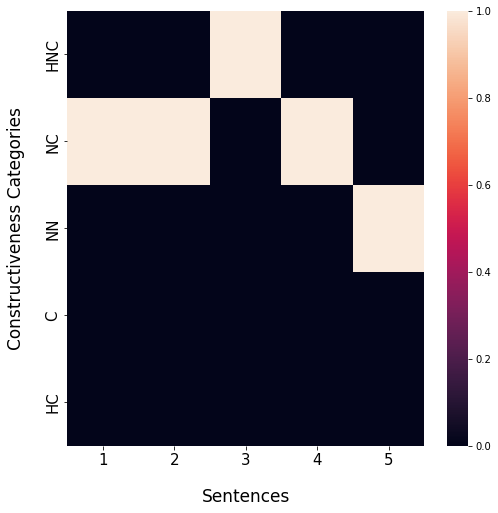

In [19]:
# cm_plotAttention(cm_matrix1 , 'Review 1', "Greens")
cm_plotAttention(cm_matrix1 , 'Review 1', "rocket")

### SAMPLE 2

In [20]:
# SAMPLE 2
# review2 = ["The manuscript looks good and can be published after fixing some minor issues I list below - congratulations!",
#            "I don't need to see the manuscript again after the changes have been implemented.",
#            '29: replace "bottleneck" with "mismatch"',
#            '29-30: that is a bold statement that in this form may not even be true: genomic data are not more comprehensive than phenomic data, and some phenotypic data are easier to collect than genomic data. you may want to rephrase this half sentence.',
#            """32: it's a good idea to introduce abbreviations for repeated mentions, but I found several instances of "high-throughput phenotyping" in the text, subtitles, and captions - replace those with HTP, or remove the HTP abbreviation (it might be more understandable to be explcit and not abbreviate)""",
#            '43: remove "nowadays,"',
#            '53: It seems that you are using 3D phenotyping and HTP/high throughput phenotyping somewhat interchangeably. in this case, it should be 3D phenotyping instead of HTP, no?',
#            """106: don't abbreviate if you don't use the abbreviation again (and multiple times) - remove "(SfM)", and check for other instances of abbreviations (e.g. "HTP")""",
#            """239: replace "Challengingly," with "Remaining challenges are that"""]
review2 = ["""The authors have nicely addressed my major concerns from the the previous review.""",
           """I have only two minor suggestions.""", 
 """1) I would suggest that the authors show quantification of their western blot data in the figures or be specifically stating the levels of change in the text.""", 
   """2) In figure 8, the authors should remove changes in metabolism that are not directly examined in the text.""", 
           """For instance, glutamine uptake and amino acid catabolism were not directly measured.""",
           """The enhance levels to TCA intermediates observed in the metabolomics study could just as easily have been derived from fatty acid metabolism."""]

op2 , cm_matrix2 = inferenceModelForHeatmap(model, embed_model, review2)

print('PREDICTED OUTPUT :', op2)
print('\n\nPREDICTED CM MATRIX :', cm_matrix2)


PREDICTED OUTPUT : [['C', array([9.5450522e-23, 9.9999595e-01, 4.0075583e-06, 8.1034684e-12,
       0.0000000e+00], dtype=float32)], ['C', array([1.286899e-30, 1.000000e+00, 2.184348e-25, 0.000000e+00,
       0.000000e+00], dtype=float32)], ['NN', array([1.9091259e-15, 2.1986847e-05, 9.9997807e-01, 2.5111145e-17,
       0.0000000e+00], dtype=float32)], ['NN', array([2.7368230e-07, 1.8704040e-06, 9.9999785e-01, 1.1697277e-29,
       0.0000000e+00], dtype=float32)], ['C', array([1.1361497e-27, 1.0000000e+00, 1.8477397e-17, 1.1390726e-23,
       0.0000000e+00], dtype=float32)], ['C', array([9.9636560e-27, 1.0000000e+00, 4.4624063e-10, 8.1761341e-22,
       0.0000000e+00], dtype=float32)]]


PREDICTED CM MATRIX : [[9.5450522e-23 9.9999595e-01 4.0075583e-06 8.1034684e-12 0.0000000e+00]
 [1.2868990e-30 1.0000000e+00 2.1843480e-25 0.0000000e+00 0.0000000e+00]
 [1.9091259e-15 2.1986847e-05 9.9997807e-01 2.5111145e-17 0.0000000e+00]
 [2.7368230e-07 1.8704040e-06 9.9999785e-01 1.1697277e-29 0.00

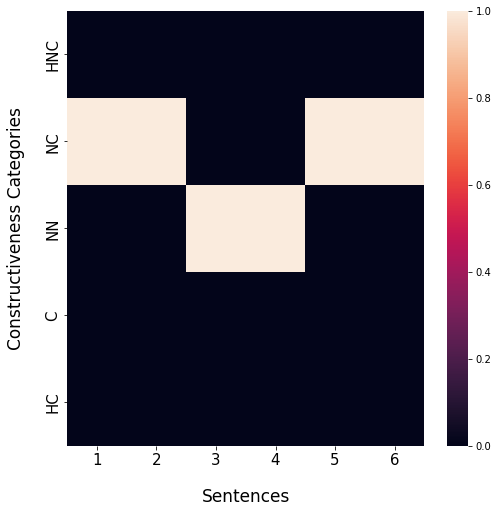

In [21]:
# cm_plotAttention(cm_matrix2 , 'Rewiew 2', 'Greens')
cm_plotAttention(cm_matrix2 , 'Rewiew 2', 'rocket')